# CNN-Pretraining: Self-Supervised Learning with Autoencoder

Encoder-Decoder structure, 

input = output, 

l2-loss between output and input, 

decouple decoder, 

save encoder, 

load on RL-model and freeze 


In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import math
import numba as nb
import skimage as io
import sklearn as sk
import pandas as pd
import os

from src.Map.Map import load_map
from src.model import Autoencoder
from src.utils import *

from tensorflow.keras.datasets import mnist
from sklearn.feature_extraction import image
from sklearn.datasets import load_sample_image

2.4.1


![autoencoder](../../res/autoencoder.png)

![autoencoder_pretrained](../../res/pretrained.png)

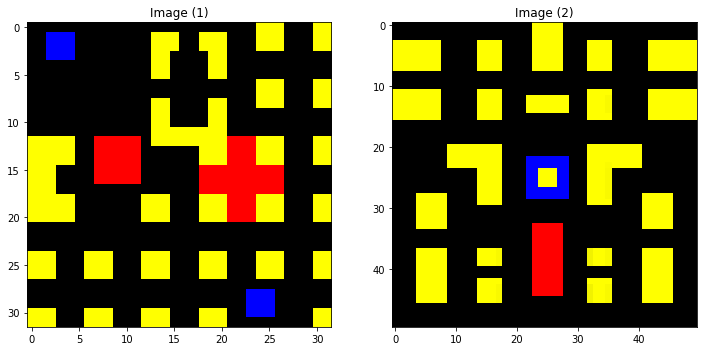

In [24]:
map_paths = ["res/manhattan32.png",
            "res/urban50.png"]

map_in = total_map = load_map(map_paths[1])
print(map_in)


img = [mpimg.imread(map_paths[0]),mpimg.imread(map_paths[1])]
  
# Output Images
# plt.imshow(img[0])
# plt.imshow(img[1])

show_images(img)

# draw_map(map_path)

Patches shape: (1412, 17, 17, 4)
Patches shape: (1412, 17, 17, 4)


/home/fede/devel/MA/CNN_Pretrain/src/utils.py:23: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  a = fig.add_subplot(cols, np.ceil(n_images / float(cols)), n + 1)


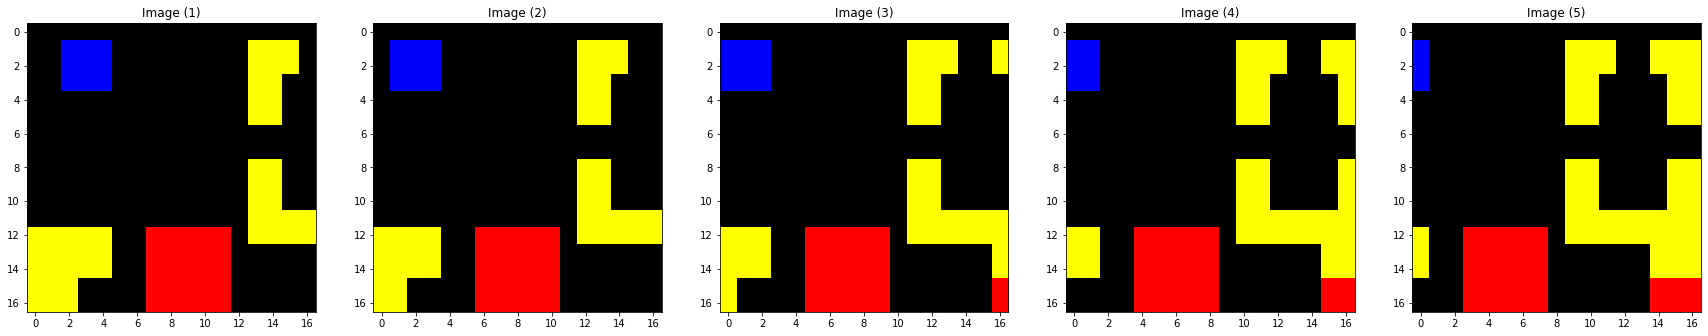

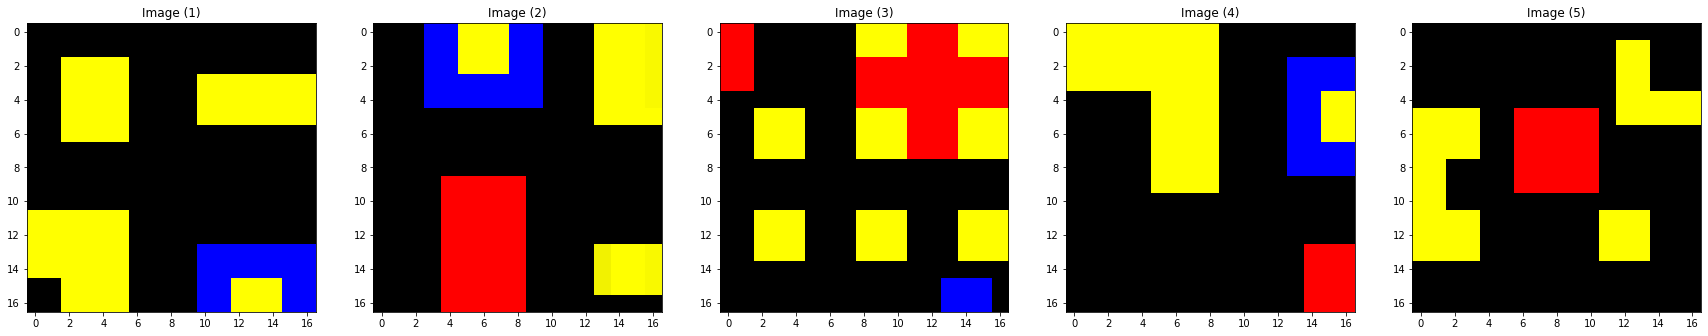

Training samples:(1129, 17, 17, 4)
Test samples:(283, 17, 17, 4)
(17, 17, 4)


In [25]:
"""
Prepare Data
"""

patches = np.concatenate((image.extract_patches_2d(img[0], (17, 17)),
                          image.extract_patches_2d(img[1], (17, 17))),
                         axis=0)

print('Patches shape: {}'.format(patches.shape))

axis_array = np.arange(len(patches[0]))

shuffled_patches = sk.utils.shuffle(patches)

print('Patches shape: {}'.format(patches.shape))

n = int(len(patches)*0.8)


show_images(patches[:5])
show_images(shuffled_patches[:5])

X_train = shuffled_patches[:n]
X_test = shuffled_patches[-(len(patches)-n):]

print("Training samples:{}".format(X_train.shape))
print("Test samples:{}".format(X_test.shape))
print(X_train[0].shape)

In [26]:
autoenc = Autoencoder(4, (X_train[0].shape))
autoenc.compile(optimizer='adam', loss='mse')

autoenc.fit(X_train, X_train,
                epochs=1,
                batch_size=32,
                shuffle=True,
                validation_data=(X_test, X_test))


ValueError: in user code:

    /home/fede/anaconda3/envs/rlvenv/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:805 train_function  *
        return step_function(self, iterator)
    /home/fede/devel/MA/CNN_Pretrain/src/model.py:59 call  *
        decoded = self.decoder(encoded)
    /home/fede/anaconda3/envs/rlvenv/lib/python3.8/site-packages/tensorflow/python/keras/engine/base_layer.py:1012 __call__  **
        outputs = call_fn(inputs, *args, **kwargs)
    /home/fede/anaconda3/envs/rlvenv/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:389 call
        outputs = layer(inputs, **kwargs)
    /home/fede/anaconda3/envs/rlvenv/lib/python3.8/site-packages/tensorflow/python/keras/engine/base_layer.py:1012 __call__
        outputs = call_fn(inputs, *args, **kwargs)
    /home/fede/anaconda3/envs/rlvenv/lib/python3.8/site-packages/tensorflow/python/keras/layers/core.py:557 call
        result.set_shape(self.compute_output_shape(inputs.shape))
    /home/fede/anaconda3/envs/rlvenv/lib/python3.8/site-packages/tensorflow/python/keras/layers/core.py:547 compute_output_shape
        output_shape += self._fix_unknown_dimension(input_shape[1:],
    /home/fede/anaconda3/envs/rlvenv/lib/python3.8/site-packages/tensorflow/python/keras/layers/core.py:536 _fix_unknown_dimension
        raise ValueError(msg)

    ValueError: total size of new array must be unchanged, input_shape = [20, 20, 1], output_shape = [17, 17, 4]


In [27]:
(X_train, _), (X_test, _) = mnist.load_data()
print("X_train", X_train.shape)
print("X_test", X_test.shape)

# print(X_train[0])

def pre_process(X):
    X = X.astype('float32') /255.0
    X = X[..., tf.newaxis]
    return X

X_train  =  pre_process(X_train)
X_test  =  pre_process(X_test)

print("X_train", X_train.shape)
print("X_test", X_test.shape)

print(X_train[0].shape)




X_train (60000, 28, 28)
X_test (10000, 28, 28)
X_train (60000, 28, 28, 1)
X_test (10000, 28, 28, 1)
(28, 28, 1)


In [28]:

num_model = Autoencoder(num_layers=4)
num_model.compile(optimizer='adam', loss='mse')

num_model.fit(X_train, X_train,
                epochs=1,
                batch_size=32,
                shuffle=True,
                validation_data=(X_test, X_test))


TypeError: __init__() missing 1 required positional argument: 'inp_shape'

In [ ]:
num_model.encoder.summary()
num_model.decoder.summary()

In [ ]:
enc_imgs = num_model.encoder(X_test).numpy()
print(enc_imgs.shape)

dec_imgs = num_model.decoder(enc_imgs).numpy()
print(dec_imgs.shape)

plot_bw_figs(10, tf.squeeze(enc_imgs[:,:,0]), 
             tf.squeeze(dec_imgs),  
             tf.squeeze(X_test))
print("enc: {} \n org: {}".format(7*7*8, 28*28))
